In [1]:
%run connect_twitter.ipynb

my API Connected !


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Gathering Data</h3><br>
Find 200 most recent tweets fom user @realDonaldTrump:

In [3]:
name = '@realDonaldTrump'
nbr_tweets = 200
results = myapi.user_timeline(id=name, count=nbr_tweets)

In [5]:
type(results)

tweepy.models.ResultSet

In [6]:
data=[tweet.text for tweet in results]


Assemble the text into a dataframe

In [7]:
data = pd.DataFrame(data=[tweet.text for tweet in results],
                    columns=['Tweets'])

In [8]:
data.head()

,Tweets
0,...Follow the money! The spy was there early i...
1,If the person placed very early into my campai...
2,"For the first time since Roe v. Wade, America ..."
3,It was my honor to welcome @NASCAR Cup Series ...
4,"Today, it was my great honor to welcome Presid..."


The interesting part from here is the quantity of metadata contained in a single tweet. If we want to obtain data such as the creation date, or the source of creation, we can access the info with this attributes. An example is the following:

In [10]:
print(dir(results[0]))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_api', '_json', 'author', 'contributors', 'coordinates', 'created_at', 'destroy', 'entities', 'favorite', 'favorite_count', 'favorited', 'geo', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'parse', 'parse_list', 'place', 'retweet', 'retweet_count', 'retweeted', 'retweets', 'source', 'source_url', 'text', 'truncated', 'user']


Getting the meta data from the first tweet in the lsit

In [11]:
print('id:',results[0].id)
print('created at:',results[0].created_at)
print('source:',results[0].source)
print('likes:',results[0].favorite_count)
print('retweets:',results[0].retweet_count)
print('geo-location:',results[0].geo)
print('message:',results[0].text)

id: 999096013674680321
created at: 2018-05-23 01:13:46
source: Twitter for iPhone
likes: 35754
retweets: 11210
geo-location: None
message: ...Follow the money! The spy was there early in the campaign and yet never reported Collusion with Russia, because… https://t.co/gJGldziTWv


<h4>Adding more data to the dataframe </h4>

In [12]:
data['len']  = np.array([len(tweet.text) for tweet in results])
data['ID']   = np.array([tweet.id for tweet in results])
data['Date'] = np.array([tweet.created_at for tweet in results])
data['Source'] = np.array([tweet.source for tweet in results])
data['Likes']  = np.array([tweet.favorite_count for tweet in results])
data['RTs']    = np.array([tweet.retweet_count for tweet in results])

In [13]:
data.head()

,Tweets,len,ID,Date,Source,Likes,RTs
0,...Follow the money! The spy was there early i...,139,999096013674680321,2018-05-23 01:13:46,Twitter for iPhone,35754,11210
1,If the person placed very early into my campai...,140,999096011174924289,2018-05-23 01:13:46,Twitter for iPhone,37530,11783
2,"For the first time since Roe v. Wade, America ...",140,999087688983764992,2018-05-23 00:40:41,Twitter for iPhone,40277,10673
3,It was my honor to welcome @NASCAR Cup Series ...,137,999010902472122368,2018-05-22 19:35:34,Twitter for iPhone,40242,8100
4,"Today, it was my great honor to welcome Presid...",134,998992271629570048,2018-05-22 18:21:32,Twitter for iPhone,50721,10753


<h3>Interpretation of the data</h3>

In [14]:
likes_max = np.max(data['Likes'])
retweet_max  = np.max(data['RTs'])

In [16]:
likes = data[data['Likes'] == likes_max].index[0]
retweets  = data[data.RTs == retweet_max].index[0]

In [17]:
retweets

190

In [18]:
# Max FAVs:
print("The tweet with most likes is: \n{}".format(data['Tweets'][likes]))
print("Number of likes: {}".format(likes_max))
print("{} characters.".format(data['len'][likes]))
print("Tweeted at {s}".format(s=data['Date'][likes]))

The tweet with most likes is: 
Thank you Kanye, very cool! https://t.co/vRIC87M21X
Number of likes: 361687
51 characters.
Tweeted at 2018-04-25 19:33:07


In [16]:
data.sort_values(by='Likes',ascending=False).head(4)

,Tweets,len,ID,Date,Source,Likes,RTs
185,"Thank you Kanye, very cool! https://t.co/vRIC8...",51,989225812166696960,2018-04-25 19:33:07,Twitter for iPhone,361736,108137
83,Five Most Wanted leaders of ISIS just captured!,47,994586105822564353,2018-05-10 14:33:00,Twitter for iPhone,301804,68903
82,The highly anticipated meeting between Kim Jon...,140,994587349718847489,2018-05-10 14:37:57,Twitter for iPhone,237822,62960
184,MAGA! https://t.co/jFf5ONASlv,29,989252420294336512,2018-04-25 21:18:51,Twitter for iPhone,233292,60118


<h3>Making Graphs</h3>

In [19]:
t_likes = pd.Series(data=data['Likes'].values, index=data['Date'])

In [20]:
t_retweets = pd.Series(data=data['RTs'].values, index=data['Date'])

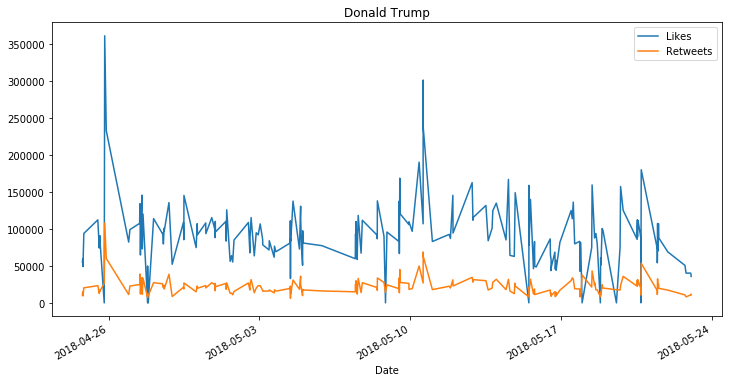

In [22]:
t_likes.plot(title='Donald Trump',
             figsize=(12,6),
             legend=True,
             label='Likes');
t_retweets.plot(legend=True,label='Retweets');

<h3>Sentiment Analysis of the Tweets</h3>

In [25]:
from textblob import TextBlob
import re

Define 2 different utility functions

In [26]:
def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analyze_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
    #analysis = TextBlob(clean_tweet(tweet))
    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [27]:
x  = [ analyze_sentiment(tweet) for tweet in data['Tweets'] ]

In [28]:
data['SA'] = np.array(x)

In [29]:
data.sort_values(by='Date',ascending=False,inplace=True)
data.head()

,Tweets,len,ID,Date,Source,Likes,RTs,SA
0,...Follow the money! The spy was there early i...,139,999096013674680321,2018-05-23 01:13:46,Twitter for iPhone,35754,11210,1
1,If the person placed very early into my campai...,140,999096011174924289,2018-05-23 01:13:46,Twitter for iPhone,37530,11783,-1
2,"For the first time since Roe v. Wade, America ...",140,999087688983764992,2018-05-23 00:40:41,Twitter for iPhone,40277,10673,1
3,It was my honor to welcome @NASCAR Cup Series ...,137,999010902472122368,2018-05-22 19:35:34,Twitter for iPhone,40242,8100,1
4,"Today, it was my great honor to welcome Presid...",134,998992271629570048,2018-05-22 18:21:32,Twitter for iPhone,50721,10753,1


The time has to be removed from the date

In [30]:
data['Date']=data['Date'].apply(lambda x : pd.to_datetime(pd.to_datetime(x).strftime('%Y%m%d')))

In [31]:
df = data.groupby('Date').sum()

In [32]:
df.head()

,len,ID,Likes,RTs,SA
Date,,,,,
2018-04-24,537.0,3.955442e+18,258079.0,55152.0,2.0
2018-04-25,778.0,6.924230e+18,959102.0,263896.0,6.0
2018-04-26,198.0,1.979280e+18,181491.0,34037.0,2.0
2018-04-27,1525.0,1.088855e+19,928447.0,233904.0,3.0
2018-04-28,1038.0,7.921789e+18,767884.0,185814.0,1.0


In [34]:
df['mood']= df['SA'].rolling(window=5).apply(lambda x : np.sum(x))

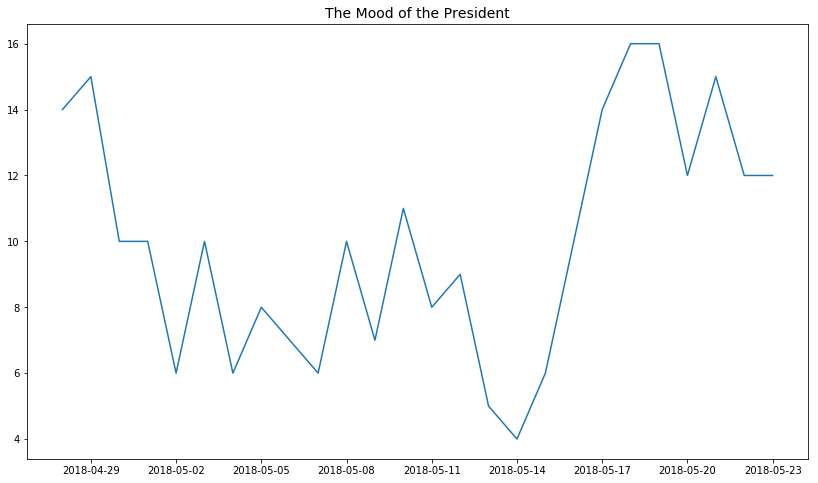

In [35]:
fig = plt.subplots(1,1,figsize=(14,8))
plt.plot(df.index,df['mood'])
plt.title('The Mood of the President',fontsize=14);

In [36]:
pos_tweets = [ tweet for index,tweet in enumerate(data['Tweets']) if data['SA'][index] > 0]
neu_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] == 0]
neg_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] < 0]

In [37]:
print(len(pos_tweets))
print(len(neu_tweets))
print(len(neg_tweets))

106
50
44


<h4>Most Liked positive tweet</h4>

In [40]:
df_positive = data[data['SA']>0].copy()
df_positive.sort_values(by='Likes',ascending=False,inplace=True)
df_positive.head(20)

,Tweets,len,ID,Date,Source,Likes,RTs,SA
190,"Thank you Kanye, very cool! https://t.co/vRIC8...",51,989225812166696960,2018-04-25,Twitter for iPhone,361687,108111,1
88,Five Most Wanted leaders of ISIS just captured!,47,994586105822564353,2018-05-10,Twitter for iPhone,301792,68883,1
87,The highly anticipated meeting between Kim Jon...,140,994587349718847489,2018-05-10,Twitter for iPhone,237819,62943,1
90,"On behalf of the American people, WELCOME HOME...",71,994517833357946882,2018-05-10,Twitter for iPhone,190525,49892,1
95,I am pleased to inform you that Secretary of S...,140,994192995737096192,2018-05-09,Twitter for iPhone,168835,45134,1
65,Our great First Lady is doing really well. Wil...,123,996366330436648960,2018-05-15,Twitter for iPhone,159078,21194,1
25,Great to have our incredible First Lady back h...,140,997909163379449857,2018-05-19,Twitter for iPhone,157535,23547,1
68,Heading over to Walter Reed Medical Center to ...,140,996135379802755072,2018-05-14,Twitter for iPhone,149174,22781,1
181,Kanye West has performed a great service to th...,140,989854486310113282,2018-04-27,Twitter for iPhone,145801,34186,1
165,Just got recent Poll - much higher than Presid...,106,990559834020962304,2018-04-29,Twitter for iPhone,145466,26892,1


<b> What about the stock market </b>

In [41]:
from googlefinance.client import get_price_data

In [42]:
param_SPX = {'q': ".INX","p" : "1Y",'i': "86400"}

In [45]:
df_SPX = get_price_data(param_SPX)
df_SPX.head()

,Open,High,Low,Close,Volume
2017-05-23 22:00:00,2397.04,2400.85,2393.88,2398.42,1770956038
2017-05-24 22:00:00,2401.41,2405.58,2397.99,2404.39,1797590258
2017-05-25 22:00:00,2409.54,2418.71,2408.01,2415.07,2010590494
2017-05-26 22:00:00,2414.50,2416.68,2412.20,2415.82,1524512471
2017-05-30 22:00:00,2411.67,2415.26,2409.43,2412.91,1776698945


In [47]:
df_SPX.index = pd.to_datetime(df_SPX.index).strftime('%Y%m%d')
df.index = pd.to_datetime(df.index).strftime('%Y%m%d')
df_combination = pd.concat([df_SPX['Close'],df['mood']],axis=1)
df_combination.dropna(how='any',inplace=True)

In [48]:
df_combination['mood']= 100*df_combination['mood']/df_combination['mood'].values[0]
df_combination['Close']= 100*df_combination['Close']/df_combination['Close'].values[0]

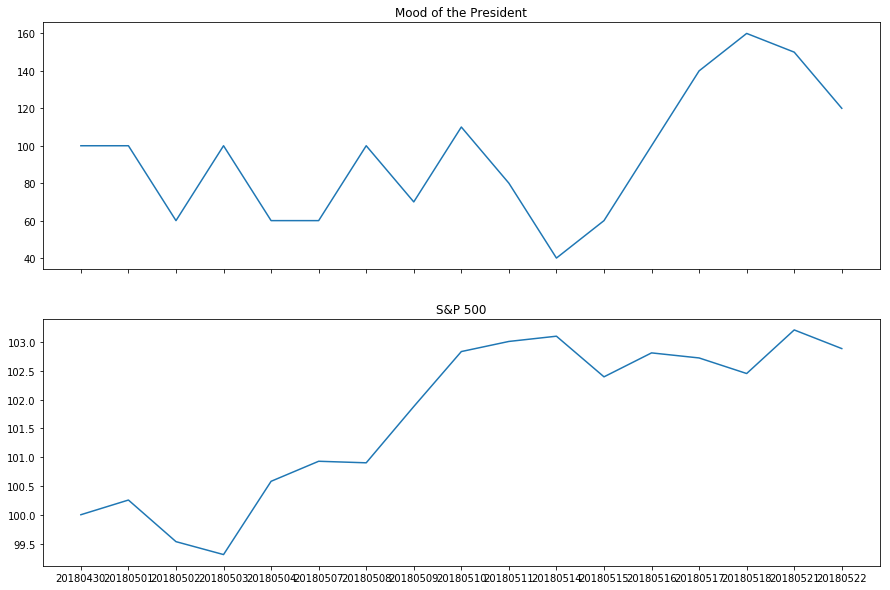

In [49]:
fig, ax = plt.subplots(2,1,figsize=(15,10),sharex=True)
ax[0].plot(df_combination.index,df_combination['mood'])
ax[0].set_title('Mood of the President')
ax[1].plot(df_combination.index,df_combination['Close'])
ax[1].set_title('S&P 500');